In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta, datetime

from simglucose.sensor.cgm import CGMSensor
from simglucose.simulation.env import T1DSimEnv
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.sim_engine import SimObj, sim
from simglucose.simulation.scenario import CustomScenario
from simglucose.controller.basal_bolus_ctrller import BBController

In [2]:
# config
GLOBAL_SEED = 0
RESULTS_PATH = "results/"
START_TIME = datetime.now()

# better plots
sns.set()

In [3]:
orig_params = pd.read_csv("../simglucose/simglucose/params/vpatient_params.csv")
nominal_params = orig_params.mean(numeric_only=True)
est_params = ["kp2", "k1", "k2", "kp1", "ki", "ke1", "kmax", "kmin", "kabs", "kp3"]

In [4]:
def construct_params(p):
    # p = [kp2, k1, k2, kp1, ki, ke1, kmax, kmin, kabs, kp3]
    return {
        **nominal_params.drop("i").to_dict(),
        **dict(zip(est_params, p)),
    }

In [5]:
# construct parameter array
pvec = [nominal_params[k] for k in est_params]
custom_params = construct_params(pvec)

In [6]:
# Create a simulation environment
patient = T1DPatient.withName("adult#001") #.withParams(custom_params)
sensor = CGMSensor.withName("Dexcom", seed=GLOBAL_SEED)
pump = InsulinPump.withName("Insulet")

scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)]
scenario = CustomScenario(start_time=START_TIME, scenario=scen)

env = T1DSimEnv(patient, sensor, pump, scenario)

# Create a controller
controller = BBController()

# Put them together to create a simulation object
s = SimObj(env, controller, timedelta(days=1), animate=False, path=RESULTS_PATH)
results = sim(s)

Process ID: 11328
Simulation starts ...
Simulation Completed!


In [7]:
results

,BG,CGM,CHO,insulin,LBGI,HBGI,Risk
Time,,,,,,,
2023-04-14 22:37:46.855302,138.560000,161.673198,0.0,0.021125,0.000000,1.510902,1.510902
2023-04-14 22:40:46.855302,138.560000,160.359506,0.0,0.021125,0.000000,1.510902,1.510902
2023-04-14 22:43:46.855302,138.560000,159.285499,0.0,0.021125,0.000000,1.510902,1.510902
2023-04-14 22:46:46.855302,138.560000,158.295766,0.0,0.021125,0.000000,1.510902,1.510902
2023-04-14 22:49:46.855302,138.560000,157.552340,0.0,0.021125,0.000000,1.510902,1.510902
...,...,...,...,...,...,...,...
2023-04-15 22:25:46.855302,106.113865,118.143612,0.0,0.021125,0.119117,0.000000,0.119117
2023-04-15 22:28:46.855302,105.445625,115.975283,0.0,0.021125,0.146170,0.000000,0.146170
2023-04-15 22:31:46.855302,104.744227,114.819748,0.0,0.021125,0.177751,0.000000,0.177751


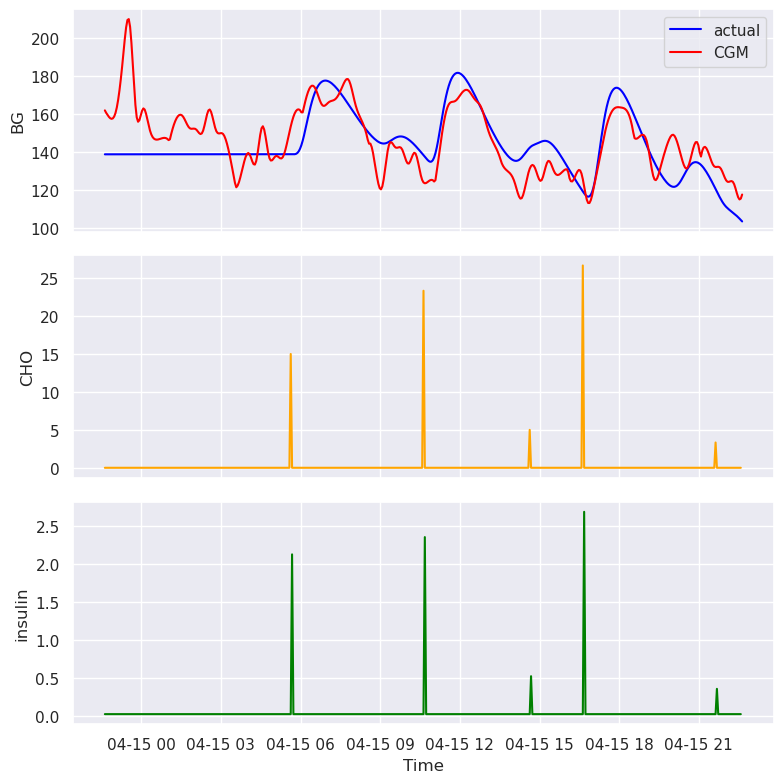

In [8]:
fig, ax = plt.subplots(3, sharex=True, figsize=(8, 8))
sns.lineplot(x="Time", y="BG", color="blue", data=results, ax=ax[0], label="actual")
sns.lineplot(x="Time", y="CGM", color="red", data=results, ax=ax[0], label="CGM")
sns.lineplot(x="Time", y="CHO", color="orange", data=results, ax=ax[1])
sns.lineplot(x="Time", y="insulin", color="green", data=results, ax=ax[2])
plt.tight_layout()
plt.show()